### PRE-TRAINING MODEL ON MNIST DATA

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Loading MNIST dataset
mnist = tf.keras.datasets.mnist

In [3]:
# Split dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Scaling values of x_train and x_test so they lie between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
# Building pre-trained model

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Fitting the model
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
60000/60000 [==============================] - 1s 15us/step - loss: 2.3773 - acc: 0.0998
Epoch 2/5
60000/60000 [==============================] - 1s 10us/step - loss: 2.1293 - acc: 0.3216
Epoch 3/5
60000/60000 [==============================] - 1s 10us/step - loss: 1.8915 - acc: 0.5426
Epoch 4/5
60000/60000 [==============================] - 1s 10us/step - loss: 1.6761 - acc: 0.6536
Epoch 5/5
60000/60000 [==============================] - 1s 11us/step - loss: 1.4784 - acc: 0.7034


In [9]:
# Evaluating on test set
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 64us/step


[1.276999604988098, 0.7514]

##### Using Session :

In [10]:
image_input = tf.placeholder(tf.float32, shape = x_train.shape)
image_label = tf.placeholder(tf.int32, shape = y_train.shape)

In [11]:

def modelFunc(inputs):
    l1 = tf.contrib.layers.flatten(inputs)
    l2 = tf.contrib.layers.fully_connected(l1, 512, activation_fn=tf.nn.relu)
    l3 = tf.contrib.layers.dropout(l2, keep_prob=0.2)
    l4 = tf.contrib.layers.fully_connected(l3, 10, activation_fn=tf.nn.softmax)
    return l4

image_predict = modelFunc(image_input)

loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(image_label, image_predict))
accuracy = tf.reduce_mean(tf.metrics.accuracy(image_label, tf.cast(tf.argmax(image_predict, 1), tf.int32)))

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss, var_list = weights)

In [12]:
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(201):
        _, loss_value, acc_value, wt_value = sess.run([optimizer, loss, accuracy, weights], feed_dict={image_input: x_train, image_label: y_train})
        if i % 20 == 0 :
            print("#", i, "Loss:", loss_value, "Accuracy:", acc_value)

# 0 Loss: 2.2993646 Accuracy: 0.057675
# 1 Loss: 2.2639685 Accuracy: 0.1382125
# 2 Loss: 2.2192667 Accuracy: 0.18642639
# 3 Loss: 2.1699631 Accuracy: 0.23513055
# 4 Loss: 2.1223361 Accuracy: 0.27865332


In [20]:
image_label.shape

TensorShape([Dimension(60000)])

In [9]:
image_predict.shape

TensorShape([Dimension(60000), Dimension(10)])

### ADDING NOISE TO SINGLE IMAGE

In [21]:
# Plots the given image
def showImg(image, graphName):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.title(graphName)

# Function keeps adding random noise to each pixel of given image until model misclassifies
def noiseTillMisclassifySingle(testImg, trueVal, scalingFactor):
    noOfIter = 0
    while np.argmax(model.predict(testImg)[0]) == trueVal:
        # Generate random noise from gaussian distribution with mean 0 and std dev 1
        noise = np.random.normal(loc=0.0, scale=1.0, size=(28,28))
        # Scales the noise accordingly (since all images initially were scaled from [0,255] to [0,1])
        noise = noise/scalingFactor
        # Add noise to image
        testImg[0] = testImg[0] + noise
        noOfIter += 1
    # Returns the number of iterations it took to misclassify
    return noOfIter

def singleMain(imgIndex, scalingFactor):
    # Image to which noise is to be added
    faultImg = np.copy(x_test[imgIndex : (imgIndex + 1)])
    # True value of image
    trueVal = np.copy(y_test[imgIndex : (imgIndex + 1)])
    
    noOfIter = noiseTillMisclassifySingle(faultImg, trueVal, scalingFactor)
    showImg(faultImg[0], str('Noise added misclassified image ('+str(scalingFactor)+')'))
    print('With scaling factor =', scalingFactor, ' No. of iterations to misclassify :', noOfIter)

With scaling factor = 255.0  No. of iterations to misclassify : 28609
With scaling factor = 50.0  No. of iterations to misclassify : 315
With scaling factor = 10.0  No. of iterations to misclassify : 109
With scaling factor = 2.0  No. of iterations to misclassify : 24


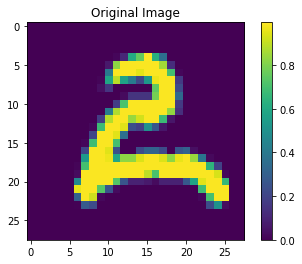

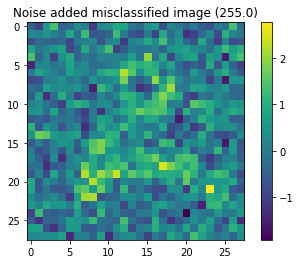

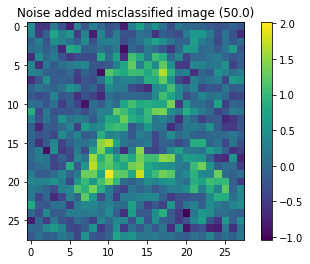

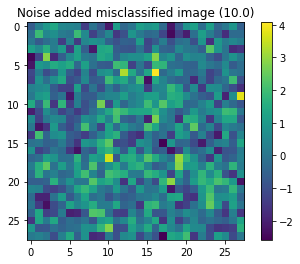

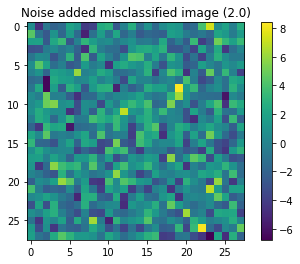

In [22]:
# Different images take different number of iterations to misclassify (run this cell multiple times to check)
randomIndex = np.random.randint(low=0, high=x_test.shape[0])

# Trying with different scaling factors for noise
scales = [255.0, 50.0, 10.0, 2.0]

showImg(x_test[randomIndex : (randomIndex + 1)][0], 'Original Image')
for x in scales:
    singleMain(randomIndex, x)


### ADDING NOISE TO COMPLETE SET

In [26]:
def noiseTillMisclassifyMultiple(faultImgColl, trueValColl, thresAccu, scalingFactor):
    noOfIter = 0
    # Keep adding noise till accuracy of model drops to thresAccu
    while model.evaluate(faultImgColl, trueValColl, verbose=0)[1] > thresAccu:
        noiseColl = np.random.normal(loc=0.0, scale=1.0, size=(x_test.shape[0], 28,28))
        noiseColl = noiseColl/scalingFactor
        faultImgColl = faultImgColl + noiseColl
        noOfIter += 1
    return noOfIter


In [27]:
faultImgColl = np.copy(x_test)
trueValColl = np.copy(y_test)

# We need to keep adding noise till model accuracy drops to threshold accuracy
thresholdAccuracies = [0.95, 0.90, 0.85, 0.80]
# Scaling factor for noise
scalingFactors = [50.0, 10.0, 2.0]

for scale in scalingFactors:
    for thresh in thresholdAccuracies:
        noOfIter = noiseTillMisclassifyMultiple(faultImgColl, trueValColl, thresh, scale)
        print('With scaling factor =', scale, ' No. of iterations to drop accuracy to', thresh, 'is', noOfIter)

With scaling factor = 50.0  No. of iterations to drop accuracy to 0.95 is 148
With scaling factor = 50.0  No. of iterations to drop accuracy to 0.9 is 336
With scaling factor = 50.0  No. of iterations to drop accuracy to 0.85 is 499
With scaling factor = 50.0  No. of iterations to drop accuracy to 0.8 is 665
With scaling factor = 10.0  No. of iterations to drop accuracy to 0.95 is 7
With scaling factor = 10.0  No. of iterations to drop accuracy to 0.9 is 14
With scaling factor = 10.0  No. of iterations to drop accuracy to 0.85 is 20
With scaling factor = 10.0  No. of iterations to drop accuracy to 0.8 is 26
With scaling factor = 2.0  No. of iterations to drop accuracy to 0.95 is 1
With scaling factor = 2.0  No. of iterations to drop accuracy to 0.9 is 1
With scaling factor = 2.0  No. of iterations to drop accuracy to 0.85 is 1
With scaling factor = 2.0  No. of iterations to drop accuracy to 0.8 is 2
